## Imports

In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

In [2]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet preliz)"

In [3]:
import utils

In [4]:
%load_ext autoreload
%autoreload 2

import arviz as az
import xarray as xr
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
plt.rcParams['figure.figsize'] = [8, 3]

dir_name = "/aux/code/book.2018.Martin.Bayesian_Analysis_with_Python.2e"

In [8]:
#%xmode minimal
%xmode plain

Exception reporting mode: Plain


# Thinking probabilistically

# Programming probabilistically

# Hierarchical models

# Modeling with linear regression

## Synthetic example

In [3]:
np.random.seed(1)

# Number of samples.
N = 100

# Parameters.
alpha_real = 2.5
beta_real = 0.9
sigma_eps_real = 0.5

# Generate data.
x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x

# Add noise.
eps_real = np.random.normal(0, sigma_eps_real, size=N)
y = y_real + eps_real

In [ ]:
#print(x, y_real)

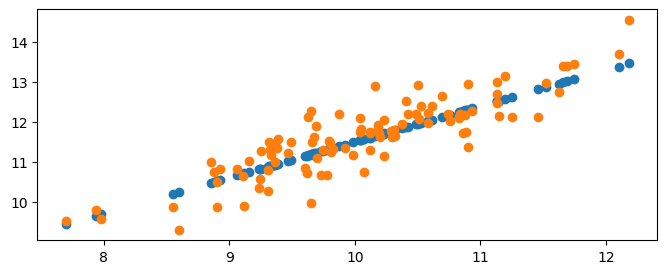

In [5]:
plt.scatter(x, y_real)
plt.scatter(x, y);

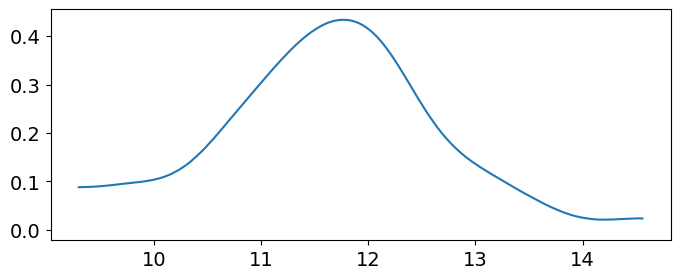

In [6]:
az.plot_kde(y);

In [10]:
with pm.Model() as model_g:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfCauchy("sigma", 5)
    #
    mu = pm.Deterministic("mu", alpha + beta * x)
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=y)
    idata_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


In [11]:
idata_g

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [22]:
print(alpha_real, beta_real, sigma_eps_real)

2.5 0.9 0.5


In [20]:
az.summary(idata_g, var_names="alpha beta sigma".split(), kind="stats")
# (idhata_g)

,mean,sd,hdi_3%,hdi_97%
alpha,2.117,0.556,1.014,3.105
beta,0.946,0.055,0.843,1.049
sigma,0.475,0.034,0.411,0.538


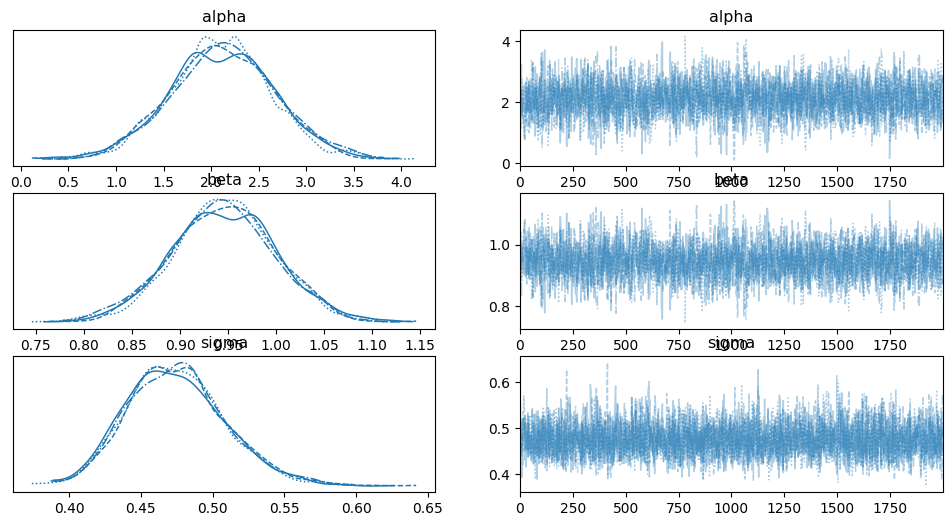

In [24]:
az.plot_trace(idata_g, var_names=["alpha", "beta", "sigma"]);

## Linear bikes

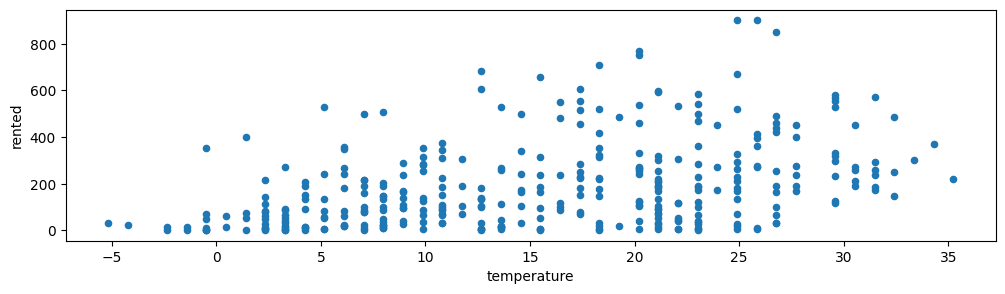

In [28]:
bikes = pd.read_csv(dir_name + "/data2/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter");

In [29]:
bikes.head()

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0


In [153]:
bikes.shape

(348, 6)

In [36]:
with pm.Model() as model_lb:
    alpha = pm.Normal("alpha", mu=0, sigma=100)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", 10)
    #
    mu = pm.Deterministic("mu", alpha + beta * bikes.temperature)
    #
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=bikes.rented)
    idata_lb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [214]:
def outdent(txt: str, n_spaces: int = 4) -> str:
    txt = "\n".join([" " * n_spaces + s for s in txt.split("\n")])
    return txt

from typing import Any, Optional
    

def obj_to_str(obj: Any, tag: str ="", only_schema: bool =True, print_: bool =True) -> Optional[str]:
    """
    - param only_schema: only print information about the shape / schema
        - If False prints also a snippet of the data
    - param print: print or return as a string
    """
    import arviz
    import xarray
    
    txt = []
    if isinstance(obj, arviz.InferenceData):
        txt.append("type: az.InferenceData")
        for k in obj.keys():
            txt.append("* %s" % k)
            # We only need to extract the string and then we decide to print or
            # return it, at the end of the recursion.
            txt_tmp = obj_to_str(obj[k], only_schema=only_schema, print_=False)
            txt.append(outdent(txt_tmp))
    elif isinstance(obj, xarray.Dataset):
        txt.append("type: xr.Dataset")
        txt.append("Dimensions: " + str(list(obj.dims)))
        txt.append(str(obj.coords))
        txt.append(str(obj.data_vars))
        if not only_schema:
            for dv in obj.data_vars.keys():
                txt.append(str(obj[dv].to_dataframe().head()))
    elif isinstance(obj, xarray.DataArray):
        txt.append("type: xr.DataArray")
        txt.append("Dimensions: " + str(list(obj.dims)))
        txt.append(str(obj.coords))
        txt.append("shape:" + str(obj.shape))
        if not only_schema:
            txt.append(str(obj.to_dataframe().head()))
    else:
        raise ValueError("Invalid %s" % type(obj))
    txt = "\n".join(txt)
    if tag:
        # Indent and add a tag.
        txt = outdent(txt)
        txt = "# %s:\n" % tag + txt
    if print_:
        print(txt)
    else:
        return txt

In [169]:
idata_lb["posterior"]["alpha"].to_dataframe()

alpha
chain draw            
0     0      50.878630
      1      49.294930
      2      63.894989
      3      55.579859
      4      55.579859
...                ...
3     995    65.184368
      996    58.493564
      997   119.102962
      998    28.628397
      999    55.692080

[4000 rows x 1 columns]

In [168]:
obj_to_str(idata_lb)

type: az.InferenceData
* posterior
    type: xr.Dataset
    Dimensions: ['chain', 'draw', 'mu_dim_0']
    Coordinates:
      * chain     (chain) int64 32B 0 1 2 3
      * draw      (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
      * mu_dim_0  (mu_dim_0) int64 3kB 0 1 2 3 4 5 6 ... 341 342 343 344 345 346 347
    Data variables:
        alpha    (chain, draw) float64 32kB 50.88 49.29 63.89 ... 119.1 28.63 55.69
        beta     (chain, draw) float64 32kB 9.006 9.046 8.277 ... 6.41 9.778 8.201
        mu       (chain, draw, mu_dim_0) float64 11MB 80.42 46.56 ... 82.59 121.1
        sigma    (chain, draw) float64 32kB 173.6 172.7 170.2 ... 178.2 166.2 177.1
* sample_stats
    type: xr.Dataset
    Dimensions: ['chain', 'draw']
    Coordinates:
      * chain    (chain) int64 32B 0 1 2 3
      * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    Data variables:
        acceptance_rate        (chain, draw) float64 32kB 1.0 0.9848 ... 0.9948
    

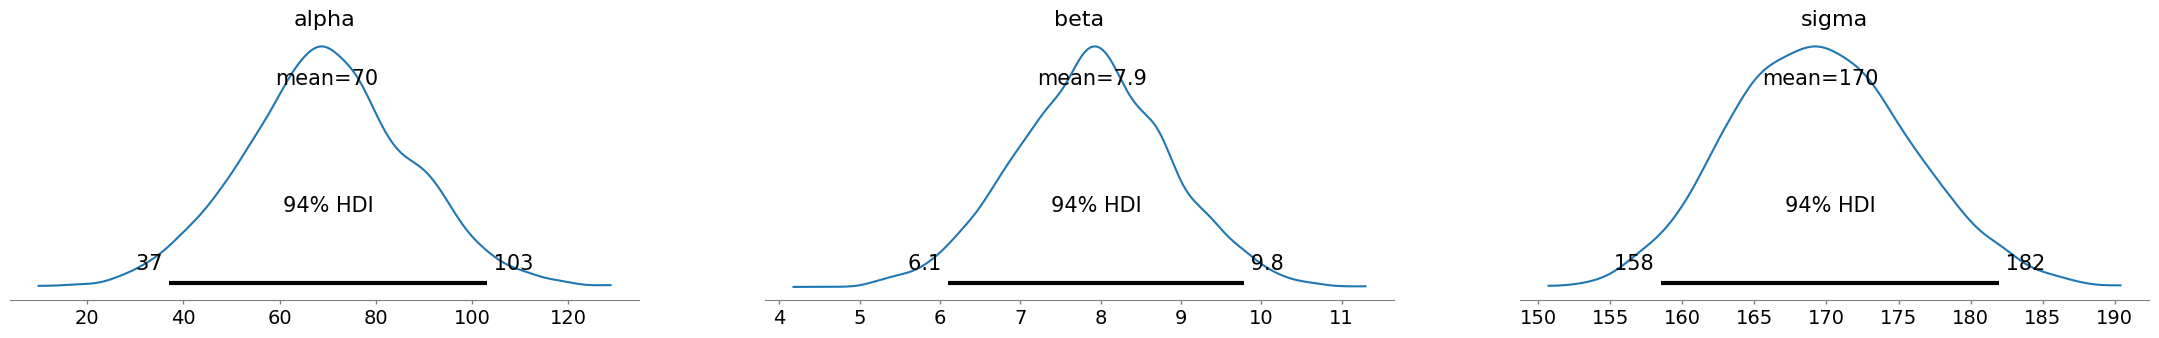

In [40]:
# Plot all the vars, excluding mu.
az.plot_posterior(idata_lb, var_names=["~mu"]);

- When the temperature is 0, the expected value of rented bikes is 69
- Every degree, the expected value increases of 7.9
- The posterior tells us that the value can increase between 6.1 and 9.8
- There is also uncertainty from the value of sigma

In [41]:
# Sample from the posterior.
posterior = az.extract(idata_lb, num_samples=50)

In [53]:
print(posterior)

<xarray.Dataset> Size: 144kB
Dimensions:   (sample: 50, mu_dim_0: 348)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 3kB 0 1 2 3 4 5 6 ... 341 342 343 344 345 346 347
  * sample    (sample) object 400B MultiIndex
  * chain     (sample) int64 400B 2 0 1 3 3 1 0 1 2 0 2 ... 2 2 3 1 0 0 0 3 0 1
  * draw      (sample) int64 400B 965 745 489 306 844 913 ... 606 778 668 79 3
Data variables:
    alpha     (sample) float64 400B 68.22 51.27 79.44 ... 58.61 65.39 68.05
    beta      (sample) float64 400B 7.826 9.201 6.712 7.386 ... 8.116 8.835 7.31
    mu        (mu_dim_0, sample) float64 139kB 93.89 81.45 101.5 ... 135.9 126.4
    sigma     (sample) float64 400B 164.2 174.3 176.2 ... 167.8 173.0 157.2
Attributes:
    created_at:                 2024-09-07T13:34:30.517443+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              1.4844932556152344
    tuning_steps:               1000


In [121]:
obj_to_str(idata_lb["posterior"])

type: xr.Dataset
Dimensions: ['chain', 'draw', 'mu_dim_0']
Coordinates:
  * chain     (chain) int64 32B 0 1 2 3
  * draw      (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * mu_dim_0  (mu_dim_0) int64 3kB 0 1 2 3 4 5 6 ... 341 342 343 344 345 346 347
Data variables:
    alpha    (chain, draw) float64 32kB 50.88 49.29 63.89 ... 119.1 28.63 55.69
    beta     (chain, draw) float64 32kB 9.006 9.046 8.277 ... 6.41 9.778 8.201
    mu       (chain, draw, mu_dim_0) float64 11MB 80.42 46.56 ... 82.59 121.1
    sigma    (chain, draw) float64 32kB 173.6 172.7 170.2 ... 178.2 166.2 177.1


In [122]:
obj_to_str(posterior)

type: xr.Dataset
Dimensions: ['sample', 'mu_dim_0']
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 3kB 0 1 2 3 4 5 6 ... 341 342 343 344 345 346 347
  * sample    (sample) object 400B MultiIndex
  * chain     (sample) int64 400B 2 0 1 3 3 1 0 1 2 0 2 ... 2 2 3 1 0 0 0 3 0 1
  * draw      (sample) int64 400B 965 745 489 306 844 913 ... 606 778 668 79 3
Data variables:
    alpha    (sample) float64 400B 68.22 51.27 79.44 71.84 ... 58.61 65.39 68.05
    beta     (sample) float64 400B 7.826 9.201 6.712 7.386 ... 8.116 8.835 7.31
    mu       (mu_dim_0, sample) float64 139kB 93.89 81.45 101.5 ... 135.9 126.4
    sigma    (sample) float64 400B 164.2 174.3 176.2 162.2 ... 167.8 173.0 157.2


### Plot 50 models sampled from the posterior

In [127]:
# Create a data array of 50 equally-spaced points from min to max temperature along the `plot_id` axis.
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id"
)
obj_to_str(x_plot, tag="x_plot")

# Compute the expected value of the model for the points.
mean_line = posterior["alpha"].mean() + posterior["beta"].mean() * x_plot
obj_to_str(mean_line, tag="mean_line")

# x_plot:
    type: xr.DataArray
    Dimensions: ['plot_id']
    Coordinates:
        *empty*
    shape:(50,)
# mean_line:
    type: xr.DataArray
    Dimensions: ['plot_id']
    Coordinates:
        *empty*
    shape:(50,)


In [128]:
# Compute 50 lines using the posterior.
lines = posterior["alpha"] + posterior["beta"] * x_plot
obj_to_str(lines, tag="lines")

# lines:
    type: xr.DataArray
    Dimensions: ['sample', 'plot_id']
    Coordinates:
      * sample   (sample) object 400B MultiIndex
      * chain    (sample) int64 400B 2 0 1 3 3 1 0 1 2 0 2 ... 2 2 2 3 1 0 0 0 3 0 1
      * draw     (sample) int64 400B 965 745 489 306 844 913 ... 606 778 668 79 3
    shape:(50, 50)


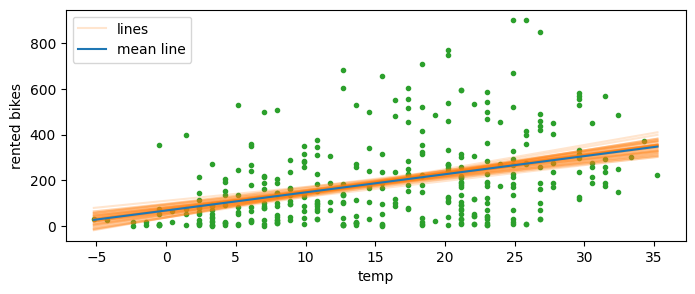

In [141]:
# - Plot the data
# zorder is to plot behind the line.
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3);

# - Plot the 50 models from the posterior.
# lines.T.values are the 50 lines.
lines_ = plt.plot(x_plot, lines.T.values, c="C1", alpha=0.2, label="lines");
# Remove the label for all the lines but the first one.
plt.setp(lines_[1:], label="_")

# Plot the mean line.
plt.plot(x_plot, mean_line, c="C0", label="mean line");

plt.xlabel("temp")
plt.ylabel("rented bikes")

plt.legend();

### Plot the confidence interval around the model

In [152]:
# Compute the hdi for all the samples.
hdi_lines = az.hdi(idata_lb.posterior["mu"])
obj_to_str(hdi_lines, tag="hdi_lines")

# hdi_lines:
    type: xr.Dataset
    Dimensions: ['mu_dim_0', 'hdi']
    Coordinates:
      * mu_dim_0  (mu_dim_0) int64 3kB 0 1 2 3 4 5 6 ... 341 342 343 344 345 346 347
      * hdi       (hdi) <U6 48B 'lower' 'higher'
    Data variables:
        mu       (mu_dim_0, hdi) float64 6kB 67.33 123.8 31.86 ... 123.8 110.0 154.6


In [170]:
hdi_lines.mu.to_pandas().head()

hdi,lower,higher
mu_dim_0,,
0,67.326925,123.796711
1,31.862060,99.271987
2,58.035266,117.120828
3,49.645237,111.475980
4,58.035266,117.120828


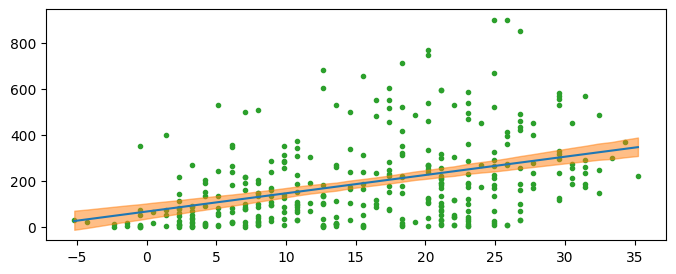

In [173]:
# Plot the data.
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3);

# - Plot the confidence interval.
# idx is a vector of the indices of the temperature so that they are in order.
idx = np.argsort(bikes.temperature.values)
plt.fill_between(
    bikes.temperature[idx],
    # First column of the HDI for mu (reordered).
    hdi_lines["mu"][:, 0][idx],
    # Second column of the HDI for mu (reordered).
    hdi_lines["mu"][:, 1][idx],
    color="C1",
    label="HDI",
    alpha=0.5
)

# Plot the average model.
plt.plot(x_plot, mean_line, c="C0", label="mean line");

### Interpreting the posterior predictions

In [175]:
idata_lb_pp = pm.sample_posterior_predictive(idata_lb, model=model_lb)

Sampling: [y_pred]


Output()

In [215]:
obj_to_str(idata_lb_pp, only_schema=False)

type: az.InferenceData
* posterior_predictive
    type: xr.Dataset
    Dimensions: ['chain', 'draw', 'y_pred_dim_2']
    Coordinates:
      * chain         (chain) int64 32B 0 1 2 3
      * draw          (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
      * y_pred_dim_2  (y_pred_dim_2) int64 3kB 0 1 2 3 4 5 ... 343 344 345 346 347
    Data variables:
        y_pred   (chain, draw, y_pred_dim_2) float64 11MB 113.5 -257.7 ... 103.7
                                 y_pred
    chain draw y_pred_dim_2            
    0     0    0             113.459799
               1            -257.662370
               2             400.972720
               3             -54.986413
               4             422.336432
* observed_data
    type: xr.Dataset
    Dimensions: ['y_pred_dim_0']
    Coordinates:
      * y_pred_dim_0  (y_pred_dim_0) int64 3kB 0 1 2 3 4 5 ... 343 344 345 346 347
    Data variables:
        y_pred   (y_pred_dim_0) float64 3kB 16.0 3.0 115.0 73.0 ... 13.0 271.0 

In [ ]:
- `posterior_predictive` contains samples from the posterior

In [218]:
mean_line = idata_lb.posteriorj["mu"].mean(("chain", "draw"))
obj_to_str(mean_line, only_schema=False)

type: xr.DataArray
Dimensions: ['mu_dim_0']
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 3kB 0 1 2 3 4 5 6 ... 341 342 343 344 345 346 347
shape:(348,)
                 mu
mu_dim_0           
0         95.657883
1         65.986905
2         88.240139
3         80.822394
4         88.240139


In [256]:
def plot_data_and_model(bikes, idata):
    # Generate a vector with the temperatures and a bit of jitter.
    temperatures = np.random.normal(bikes.temperature.values, 0.01)
    
    # Sort in increasing order.
    idx = np.argsort(temperatures)
    
    # Sample the temperature intervals.
    x = np.linspace(temperatures.min(), temperatures.max(), 15)
    
    # Compute the quantiles, flattening over chain and draw.
    y_pred_q = idata.posterior_predictive["y_pred"].quantile(
        [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"])
    #obj_to_str(y_pred_q, only_schema=False)
    
    from scipy.interpolate import PchipInterpolator
    
    y_hat_bounds = [
            PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
            for i in range(4)
    ]
    #print(y_hat_bounds)
    
    # Plot the data set.
    plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
    # Plot the mean.
    plt.plot(bikes.temperature[idx], mean_line[idx], c="C0")
    
    # Plot the quantiles.
    lb, ub = y_hat_bounds[0], y_hat_bounds[1]
    plt.fill_between(x, lb, ub, color="C1", alpha=0.2);
    lb, ub = y_hat_bounds[2], y_hat_bounds[3]
    plt.fill_between(x, lb, ub, color="C1", alpha=0.2);

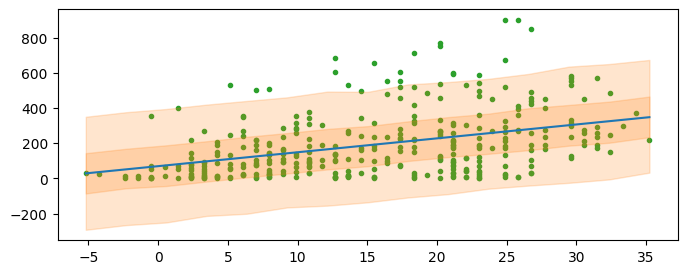

In [257]:
plot_data_and_model(bikes, idata_lb_pp)

## Counting bikes

In [250]:
np.random.seed(42)
with pm.Model() as model_neg:
    alpha = pm.Normal("alpha", mu=0, sigma=100)
    beta = pm.Normal("beta", mu=0, sigma=10)
    # We use exp to have all positive numbers.
    mu = pm.Deterministic("mu", pm.math.exp(alpha + beta * bikes.temperature))
    # NegativeBinomial has an extra param alpha to control the variance.
    sigma = pm.HalfNormal("sigma", 10)
    y_pred = pm.NegativeBinomial("y_pred", mu=mu, alpha=sigma, observed=bikes.rented)
    #
    idata_neg = pm.sample()
    idata_neg.extend(pm.sample_posterior_predictive(idata_neg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y_pred]


Output()

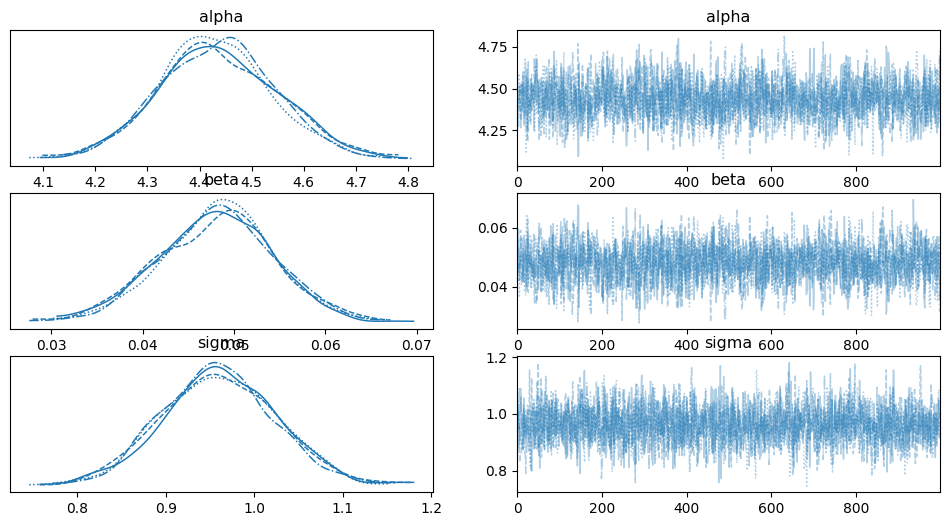

In [252]:
az.plot_trace(idata_neg, var_names=["~mu"]);

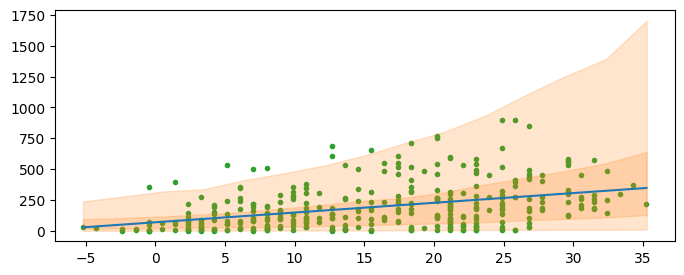

In [258]:
plot_data_and_model(bikes, idata_neg)

- The model doesn't predict negative counts
- It has larger tails for the 

<Axes: xlabel='y_pred'>

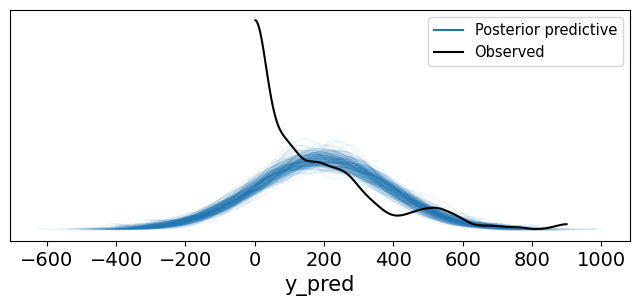

In [262]:
az.plot_ppc(
    idata_lb_pp,
    num_pp_samples=200,
    alpha=0.1,
    #colors=["C1", "CO", "CO"],
    mean=False)

## High correlation of params in linear models

In [ ]:
x2 = (x - x.mean()) / x.std()
y2 = (y - y.mean()) / y.std()

In [ ]:
plt.scatter(x2, y2)

In [ ]:
if False:
    x = x2
    y = y2
    # Rerun the cells above.

## Visualizing the posterior

In [ ]:
# Plot the samples.
plt.plot(x, y, 'C0.')

# Plot the models corresponding to a 10% subset of the posterior.
draws = range(0, len(trace_g["alpha"]), 10)
plt.plot(x,
         trace_g["alpha"][draws] + trace_g["beta"][draws] * x[:, np.newaxis],
         c="gray",
         alpha=0.1);

# Plot the model mean posterior.
alpha_m = trace_g["alpha"].mean()
beta_m = trace_g["beta"].mean()
plt.plot(x, alpha_m + beta_m * x, c="k");

# Notes:
# - the uncertainty is smaller in the middle

In [ ]:
# We can also plot the HPD directly.
# plt.plot(x,
#          alpha_m + beta_m * x,
#          c='k',
#          label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
# TODO(gp): Need a newer version of az package.
# sig = az.plot_hpd(x, trace_g['mu'], credible_interval=0.98, color='k')

In [ ]:
az.r2_score(y, y_real)

In [ ]:
# We can generate samples for future data using the psoterior predictive.
ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)
print(ppc)

In [ ]:
for i in range(0, 2000, 100):
    plt.scatter(x, ppc["y_pred"][i], color="b", alpha=0.1)

In [ ]:
az.r2_score(y, ppc["y_pred"])

## Pearson correlation coefficient

In [ ]:
# i, j = np.mgrid[0:5, 0:5]
# print(i)
# print(j)

In [ ]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.9, -0.5, 0, 0.5, 0.9]

# Create a grid of (2, 100, 100).
k, l = np.mgrid[-5:5:.1, -5:5:.1]
print("k=\n", k)
#print(k.shape, l.shape)

# `pos` is a grid of points.
pos = np.empty(k.shape + (2, ))
#pos[:, :, 0] = k
#pos[:, :, 1] = l
#print("pos= (%s)\n%s" % (pos.shape, pos))

In [ ]:
sigmas_x2 = sigmas_x2[:2]
rhos = rhos[:3]
# Create a grid of plots for each sigma_x2 and rho.
f, ax = plt.subplots(len(sigmas_x2),
                     len(rhos),
                     sharex=True,
                     sharey=True,
                     figsize=(12, 6),
                     constrained_layout=True)

# For
for i in range(len(sigmas_x2)):
    for j in range(len(rhos)):
        # Create a RV with the given covariance.
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1 * sigma_x2 * rho],
               [sigma_x1 * sigma_x2 * rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        # Sample the PDF on the `pos` points.
        ax[i, j].contour(k, l, rv.pdf(pos))

        # Tweak the plot.
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(
            0,
            0,
            label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ ={rho:3.2f}',
            alpha=0)
        ax[i, j].legend()

In [ ]:
data = np.stack((x, y)).T
print(data.shape)
#print(data)

In [ ]:
with pm.Model() as pearson_model:
    # mean is normal.
    mu = pm.Normal("mu", mu=data.mean(0), sd=10, shape=2)
    # sigmas are half-normal.
    sigma_1 = pm.HalfNormal("sigma_1", 10)
    sigma_2 = pm.HalfNormal("sigma_2", 10)
    # rho is uniform in [-1, 1].
    rho = pm.Uniform("rho", -1.0, 1.0)
    # R2 is just deterministic (to compute as part of the posterior).
    r2 = pm.Deterministic("r2", rho**2)
    # Build covariance matrix.
    cov = pm.math.stack(([sigma_1**2, sigma_1 * sigma_2 * rho],
                        [sigma_1 * sigma_2 * rho, sigma_2**2]))
    # Model.
    y_pred = pm.MvNormal("y_pred", mu=mu, cov=cov, observed=data)
    trace_p = pm.sample(1000)

In [ ]:
az.plot_trace(trace_p, var_names=["r2"])

In [ ]:
az.summary(trace_p, var_names=["r2"])

## Robust linear regression.

In [ ]:
if False:
    ans = pd.read_csv(dir_name + "/data2/anscombe.csv")
    display(ans.head())
    
    # Consider group III.
    x_3 = ans[ans.group == "III"]["x"].values
    y_3 = ans[ans.group == "III"]["y"].values
    
    # Demean to help convergence.
    x_3 -= x_3.mean()
    
    # Regress.
    beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
    print(alpha_c, beta_c)
    
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot data and model.
    ax[0].plot(x_3, (alpha_c + beta_c * x_3),
               'k',
               label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
    ax[0].plot(x_3, y_3, 'C0o')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y', rotation=0)
    ax[0].legend(loc=0)
    
    # Plot the density of y.
    az.plot_kde(y_3, ax=ax[1], rug=True)
    ax[1].set_xlabel('y')
    ax[1].set_yticks([])
    
    plt.tight_layout()

In [268]:
ans = pd.read_csv(dir_name + "/data2/anscombe_3.csv")
display(ans.head())

,x,y
0,-4.891,5.713
1,-4.272,5.613
2,-3.126,6.430
3,-1.923,6.567
4,-0.502,7.246


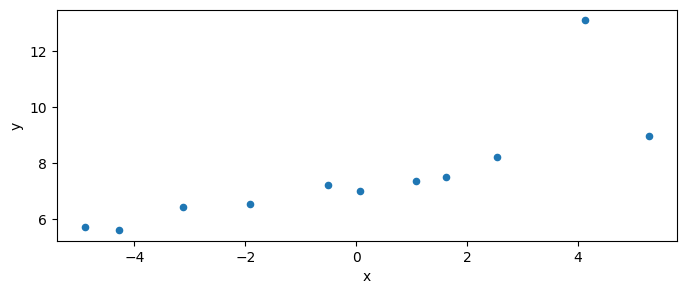

In [270]:
ans.plot("x", "y", kind="scatter");

In [284]:
with pm.Model() as model_t:
    # Alpha is normal centered around the mean of the y data.
    alpha = pm.Normal("alpha", mu=ans.y.mean(), sigma=1)
    # Beta is a standard (0, 1).
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", 5)
    # The exponential puts too much weight close to 0, so we shift by 1.
    nu_ = pm.Exponential("nu_", 1/29)
    nu = pm.Deterministic("nu", nu_ + 1)

    # Model.
    mu = pm.Deterministic("mu", alpha + beta * ans.x)
    y_pred = pm.StudentT("y_pred", mu=mu, sigma=sigma, nu=nu, observed=ans.y)
    idata_t = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu_]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%
alpha,7.22,0.15,6.97,7.45
beta,0.33,0.05,0.24,0.41
sigma,0.33,0.25,0.07,0.71
nu,2.96,7.25,1.00,4.76


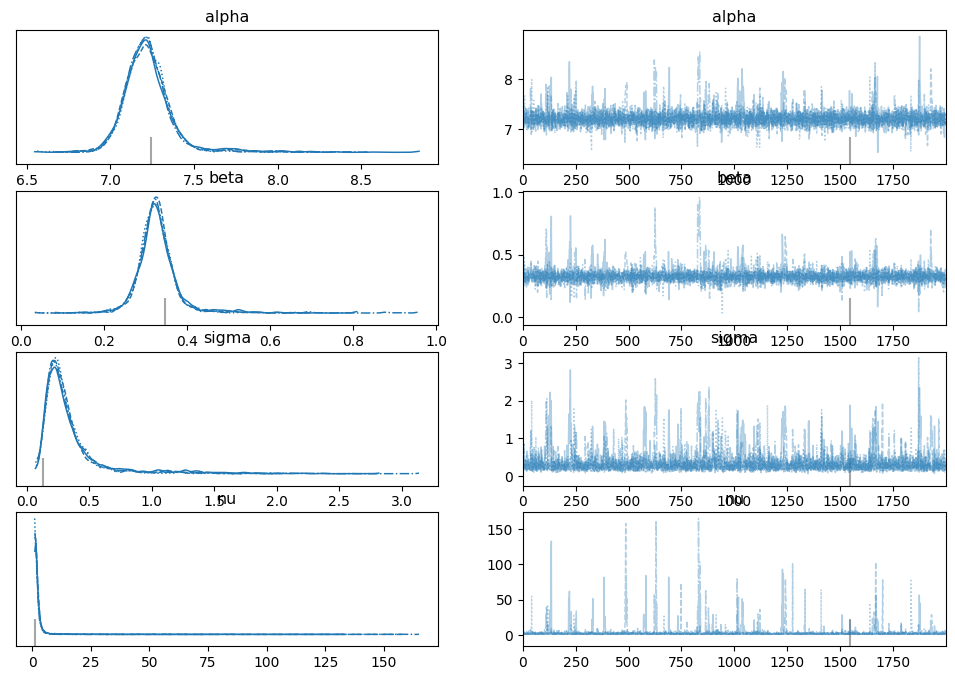

In [285]:
var_names = "alpha beta sigma nu".split()
az.plot_trace(idata_t, var_names=var_names);
az.summary(idata_t, var_names=var_names, round_to=2, kind="stats")

/venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


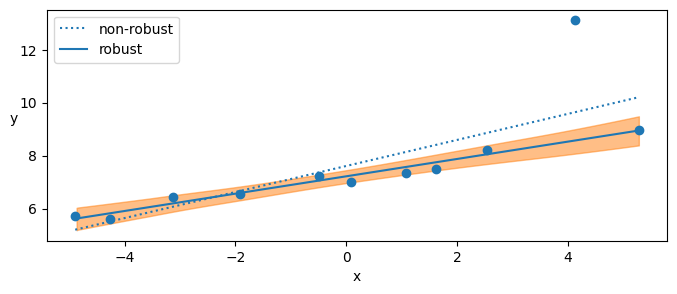

In [288]:
from scipy.stats import linregress

beta_c, alpha_c, *_ = scipy.stats.linregress(ans.x, ans.y)

_, ax = plt.subplots()
ax.plot(ans.x, (alpha_c + beta_c * ans.x), "C0:", label="non-robust")
ax.plot(ans.x, ans.y, "C0o")
alpha_m = idata_t.posterior["alpha"].mean(("chain", "draw"))
beta_m = idata_t.posterior["beta"].mean(("chain", "draw"))

x_plot = xr.DataArray(np.linspace(ans.x.min(), ans.x.max(), 50), dims="plot_id")
ax.plot(x_plot, alpha_m + beta_m * x_plot, c="C0", label="robust")
az.plot_hdi(ans.x, az.hdi(idata_t.posterior["mu"])["mu"].T, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
ax.legend(loc=2);

In [ ]:
# Posterior predictive check.

ppc = pm.sample_posterior_predictive(trace_t,
                                     samples=200,
                                     model=model_t,
                                     random_seed=2)
data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
plt.xlim(0, 12)

## Logistic regression

In [290]:
iris = pd.read_csv(dir_name + "/data/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [307]:
# Filter the dataframe keeping only 2 values for species.
df = iris.query("species == ('setosa', 'versicolor')")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [310]:
# Get the predicted variable.
y_0 = pd.Categorical(df["species"]).codes
y_0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [311]:
# Get the sepal length as feature.
x_n = "sepal_length"
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [314]:
with pm.Model() as model_lrs:
    # Linear part.
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=5)
    mu = alpha + x_c * beta
    # Sigmoid.
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    # Model.
    yl = pm.Bernoulli("yl", p=theta, observed=y_0)
    # Intercept?
    bd = pm.Deterministic("bd", - alpha / beta)
    #
    idata_lrs = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


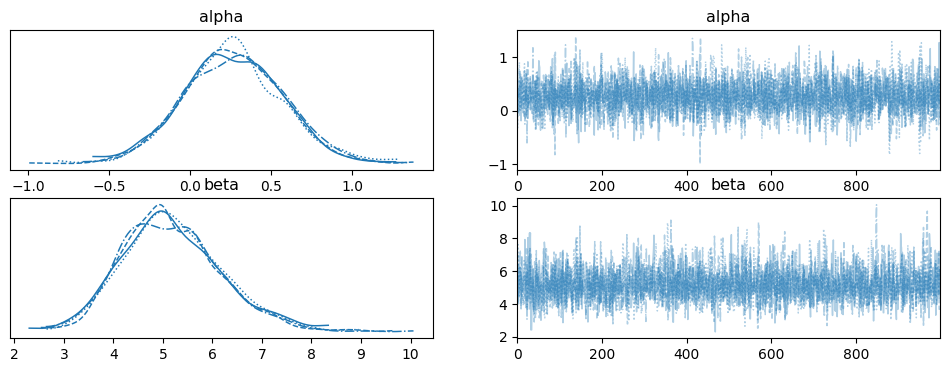

In [316]:
az.plot_trace(idata_lrs, var_names=["~bd", "~theta"]);

<Axes: >

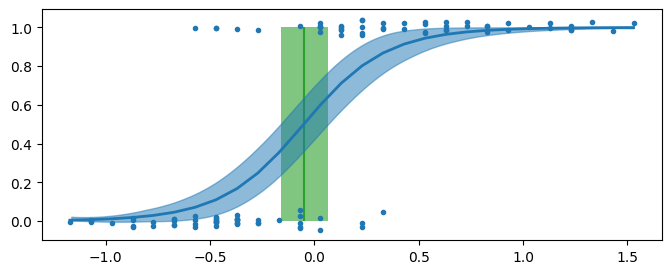

In [329]:
posterior = idata_lrs.posterior
theta = posterior["theta"].mean(("chain", "draw"))
idx = np.argsort(x_c)
#print(posterior)
#print(idx)

# Plot the model.
_, ax = plt.subplots()
ax.plot(x_c[idx], theta[idx], color="C0", lw=2)

# Plot the decision.
ax.vlines(posterior["bd"].mean(("chain", "draw")), 0, 1, color="C2", zorder=0)
bd_hdi = az.hdi(posterior["bd"])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color="C2", alpha=0.6, lw=0)

# Plot the data.
ax.scatter(x_c, np.random.normal(y_0, 0.02), marker=".")

az.plot_hdi(x_c, posterior["theta"], color="C0", ax=ax)

## Variable variance

,month,length
0,0,48.5
1,0,50.5
2,0,50.5
3,0,52.0
4,0,47.5


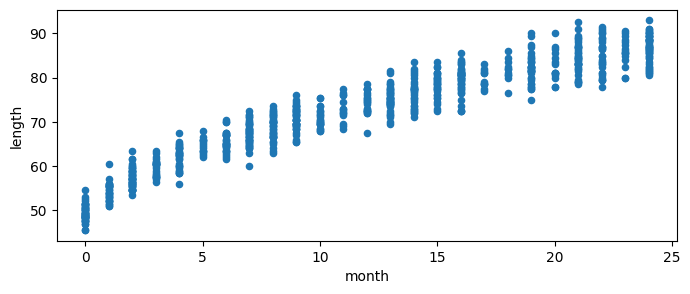

In [10]:
# Load data.
data = pd.read_csv(dir_name + "/data/babies.csv")
data.columns = ["month", "length"]
data.plot.scatter("month", "length");
display(data.head())

In [11]:
with pm.Model() as model_vv:
    # Create a shared variable so that the data can change after the model is created.
    x_shared = pm.Data("x_shared", data.month.values.astype(float))
    # Linear model for the mean is a function of sqrt(x).
    alpha = pm.Normal("alpha", sigma=10)
    beta = pm.Normal("beta", sigma=10)
    mu = pm.Deterministic("mu", alpha + beta * x_shared ** 0.5)
    # Linear model for the std dev.
    gamma = pm.HalfNormal("gamma", sigma=10)
    delta = pm.HalfNormal("delta", sigma=10)
    sigma = pm.Deterministic("sigma", gamma + delta * x_shared)
    # Fit.
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=data.length)
    #
    idata_vv = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


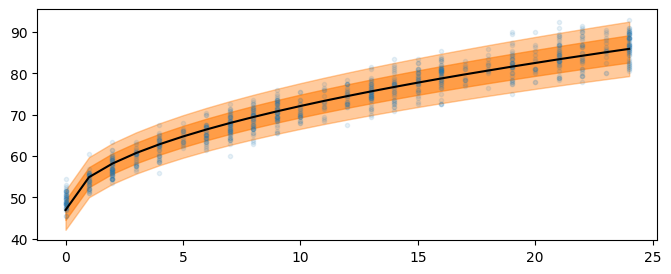

In [12]:
# Plot the data.
plt.plot(data.month, data.length, "C0.", alpha=0.1)

# Compute the posterior mean and sigma.
posterior = az.extract(idata_vv)
mu_m = posterior["mu"].mean("sample").values
sigma_m = posterior["sigma"].mean("sample").values

# Plot 1 and 2 std dev of the model.
plt.plot(data.month, mu_m, c="k")
plt.fill_between(data.month, mu_m + 1 * sigma_m, mu_m - 1 * sigma_m, alpha=0.6, color="C1")
plt.fill_between(data.month, mu_m + 2 * sigma_m, mu_m - 2 * sigma_m, alpha=0.4, color="C1")

In [14]:
# Now that we have a model we might want to evaluate the length of a particular baby (e.g., for 0.5 months).
with model_vv:
    # Set the x var in the model to 0.5.
    pm.set_data({"x_shared": [0.5]})
    # Sample the posterior predictive for that x var.
    ppc = pm.sample_posterior_predictive(idata_vv)
    y_ppc = ppc.posterior_predictive["y_pred"].stack(sample=("chain", "draw"))

Sampling: [y_pred]


Output()

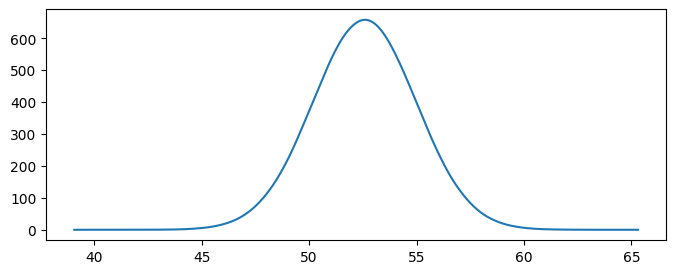

In [17]:
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)

plt.plot(grid, pdf)

## Hierarchical linear regression

In [30]:
np.random.seed(314)

# 20 values per group.
N = 20

# 8 groups.
groups = "A B C D E F G H".split()
M = len(groups)
print("M=", M)
assert M == 8

# 7 groups of 19 elements, and 1 group of one element.
# Map from idx to group.
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
#utils.print_obj("idx", idx)
print("idx=", idx)


M= 8
idx= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7]


In [31]:
# Sample ground truth parameters of the distributions for each group.
alpha_real = np.random.normal(2.5, 0.5, size=M)
print("alpha_real=", alpha_real)
beta_real = np.random.beta(6, 1, size=M)
print("beta_real=", beta_real)
eps_real = np.random.normal(0, 0.5, size=len(idx))
print("eps_real=", eps_real[:10])

# Observed x samples for each group.
x_m = np.random.normal(10, 1, len(idx))
print("x_m.shape=", x_m.shape)
# Create the observed model outcomes.
y_m = np.zeros(len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
print("y_m.shape=", y_m.shape)

alpha_real= [2.58304272 2.89098224 2.92614255 2.14646452 2.0341714  2.94333044
 2.38910517 2.69086179]
beta_real= [0.89177808 0.96075013 0.87574597 0.78793584 0.7775104  0.70400598
 0.92485907 0.93568724]
eps_real= [-0.11566774 -0.5736125  -0.21147267  0.66527348 -0.46391691  0.05263992
 -0.54877832 -0.43519044 -0.44145181  0.1996012 ]
x_m.shape= (141,)
y_m.shape= (141,)


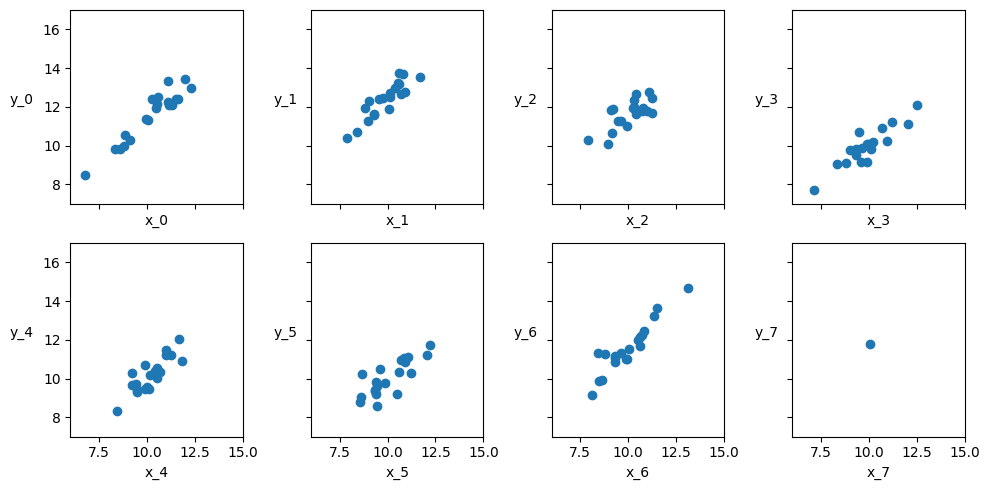

In [32]:
# Plot the 8 groups in a 2 x 4 matrix.
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

# Plot the values group by group.
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

### Non-hierarchical model

In [33]:
# Fit a non-hierarchical model.
coords = {"group": groups}

with pm.Model(coords=coords) as unpooled_model:
    # Priors.
    alpha = pm.Normal("alpha", mu=0, sigma=10, dims="group")
    beta = pm.Normal("beta", mu=0, sigma=10, dims="group")
    sigma = pm.HalfNormal("sigma", 5)
    #nu = pm.Exponential("nu", 1 / 30)

    # Model.
    y_pred = pm.Normal("y_pred",
                       mu=alpha[idx] + beta[idx] * x_m,
                       sigma=sigma,
                       observed=y_m)
    
    idata_up = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


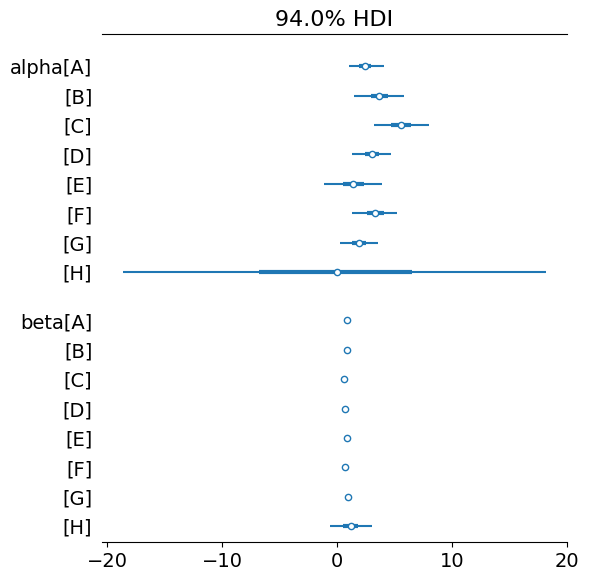

In [34]:
az.plot_forest(idata_up, var_names=["alpha", "beta"], combined=True);

In [25]:
var_names = "alpha beta sigma".split()
az.summary(idata_up, var_names=var_names, kind="stats")

,mean,sd,hdi_3%,hdi_97%
alpha[A],1.702,1.174,-0.407,4.004
alpha[B],2.814,0.770,1.323,4.196
alpha[C],0.930,1.355,-1.628,3.439
alpha[D],0.915,1.343,-1.629,3.383
alpha[E],3.794,1.199,1.369,5.895
alpha[F],3.767,0.998,1.945,5.696
alpha[G],2.980,1.410,0.308,5.589
alpha[H],0.202,10.025,-18.232,19.060
beta[A],1.028,0.115,0.803,1.231
beta[B],0.563,0.079,0.418,0.713


- It's clear that the estimation of the params for the group 7 with only one sample are very wide.
  (You can't fit a line through a single point, you need at least 2 points).

- One solution is to use hierarchical model to share information between groups.
  This is very useful for groups with sparse data.

### Hierarchical centered

In [35]:
with pm.Model(coords=coords) as hierarchical_centered:
    # Hyper-priors on alpha.
    alpha_mu = pm.Normal("alpha_mu", mu=y_m.mean(), sigma=1)
    alpha_sigma = pm.HalfNormal("alpha_sigma", 5)
    # Hyper-priors on beta.
    beta_mu = pm.Normal("beta_mu", mu=0, sigma=1)
    beta_sigma = pm.HalfNormal("beta_sigma", sigma=5)

    # Priors.
    alpha2 = pm.Normal('alpha2',
                       mu=alpha_mu,
                       sigma=alpha_sigma,
                       dims="group")
    beta2 = pm.Normal('beta2', mu=beta_mu, sigma=beta_sigma, dims="group")
    sigma2 = pm.HalfNormal('sigma2', 5)
    
    # Model.
    #y_pred = pm.StudentT('y_pred',
    y_pred = pm.Normal('y_pred',
                       mu=alpha2[idx] + beta2[idx] * x_m,
                       sigma=sigma2,
                       observed=y_m)
    
    idata_cen = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_mu, alpha_sigma, beta_mu, beta_sigma, alpha2, beta2, sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


In [29]:
var_names = "alpha2 beta2 sigma2".split()
az.summary(idata_cen, var_names=var_names, kind="stats")

,mean,sd,hdi_3%,hdi_97%
alpha2[A],2.443,1.069,0.374,4.399
alpha2[B],2.435,0.805,0.964,3.957
alpha2[C],1.929,1.186,-0.192,4.137
alpha2[D],2.155,1.219,-0.278,4.323
alpha2[E],4.152,1.039,2.237,6.096
alpha2[F],3.715,0.874,2.145,5.453
alpha2[G],3.364,1.145,1.264,5.556
alpha2[H],2.840,2.667,-2.160,7.973
beta2[A],0.955,0.104,0.771,1.162
beta2[B],0.602,0.083,0.445,0.756


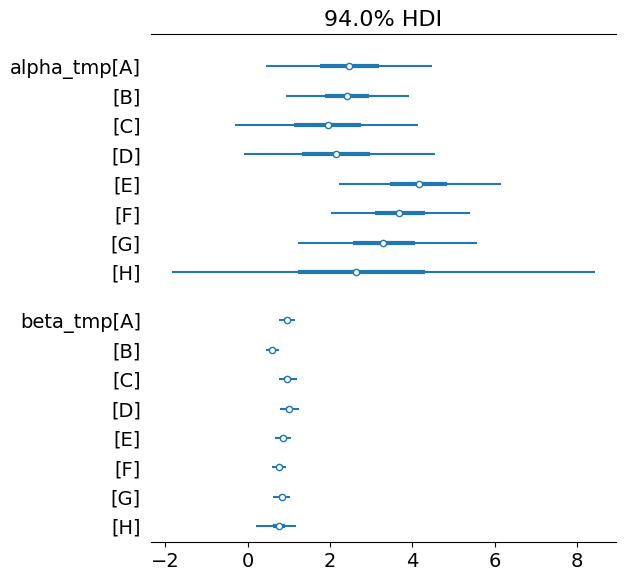

In [22]:
az.plot_forest(idata_cen, var_names=["alpha2", "beta2"], combined=True);

### Hierarchical non-centered

In [40]:
with pm.Model(coords=coords) as hierarchical_non_centered:
    # Hyper-priors (same as before).
    alpha_mu = pm.Normal("alpha_mu", mu=y_m.mean(), sigma=1)
    alpha_sigma = pm.HalfNormal("alpha_sigma", 5)
    beta_mu = pm.Normal("beta_mu", mu=0, sigma=1)
    beta_sigma = pm.HalfNormal("beta_sigma", sigma=5)

    # Priors (alpha is the same, beta is different).
    alpha3 = pm.Normal("alpha3", mu=alpha_mu, sigma=alpha_sigma, dims="group")

    beta_offset = pm.Normal("beta_offset", mu=0, sigma=1, dims="group")
    beta3 = pm.Deterministic("beta3", beta_mu + beta_offset * beta_sigma, dims="group")

    sigma3 = pm.HalfNormal("sigma3", 5)

    # Model (same as before).
    _ = pm.Normal("y_pred", mu=alpha3[idx] + beta3[idx] * x_m, sigma=sigma3, observed=y_m)

    idata_ncen = pm.sample(random_seed=123, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_mu, alpha_sigma, beta_mu, beta_sigma, alpha3, beta_offset, sigma3]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [42]:
var_names = "alpha3 beta3 sigma3".split()
az.summary(idata_ncen, var_names=var_names, kind="stats")

,mean,sd,hdi_3%,hdi_97%
alpha3[A],2.923,0.745,1.626,4.345
alpha3[B],4.297,0.844,2.769,5.985
alpha3[C],4.752,1.132,2.669,6.860
alpha3[D],2.808,0.772,1.428,4.310
alpha3[E],2.088,0.926,0.344,3.761
alpha3[F],2.865,0.918,1.323,4.666
alpha3[G],2.838,0.823,1.357,4.388
alpha3[H],4.267,1.649,0.976,7.257
beta3[A],0.847,0.072,0.717,0.978
beta3[B],0.818,0.085,0.664,0.987


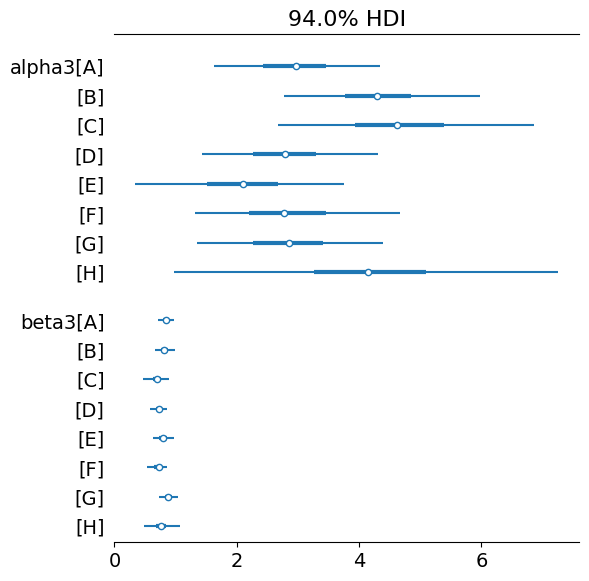

In [43]:
az.plot_forest(idata_ncen, var_names=["alpha3", "beta3"], combined=True);

## Polynomial regression

In [ ]:
x_2 = ans[ans.group == "II"]['x'].values
y_2 = ans[ans.group == "II"]['y'].values

x_2 -= x_2.mean()

plt.scatter(x_2, y_2);

In [ ]:
with pm.Model() as model_poly:
    alpha = pm.Normal("alpha", mu=y_2.mean(), sd=1)
    beta1 = pm.Normal("beta1", mu=0, sd=1)
    beta2 = pm.Normal("beta2", mu=0, sd=1)
    eps = pm.HalfCauchy("eps", 5)
    
    mu = alpha + beta1 * x_2 + beta2 * x_2 ** 2
    
    y_pred = pm.Normal("y_pred", mu=mu, sd=eps, observed=y_2)
    
    trace_poly = pm.sample(2000)

In [ ]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');

In [ ]:
var_names = "alpha beta1 beta2 eps".split()
az.summary(trace_poly, var_names=var_names, kind="stats")

### Fitting a line with a polynomial

In [ ]:
x_2 = ans[ans.group == "II"]['x'].values
y_2 = ans[ans.group == "II"]['y'].values

x_2 -= x_2.mean()

plt.scatter(x_2, y_2);

In [ ]:
with pm.Model() as model_poly:
    alpha = pm.Normal("alpha", mu=y_2.mean(), sd=1)
    beta1 = pm.Normal("beta1", mu=0, sd=1)
    beta2 = pm.Normal("beta2", mu=0, sd=1)
    eps = pm.HalfCauchy("eps", 5)
    
    mu = alpha + beta1 * x_2 + beta2 * x_2 ** 2
    
    y_pred = pm.Normal("y_pred", mu=mu, sd=eps, observed=y_2)
    
    trace_poly = pm.sample(2000)

In [ ]:
var_names = "alpha beta1 beta2 eps".split()
az.summary(trace_poly, var_names=var_names, kind="stats")

## Multiple linear regression

In [ ]:
np.random.seed(314)

N = 100
#N = 1000
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_stddev_real = 0.5
eps_real = np.random.normal(0, eps_stddev_real, size=N)

# Independent variables.
X = np.array([np.random.normal(i, j, N) for i, j in zip(
    # mean of gaussian.
    [10, 2],
    # std dev.
    [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean

# Create samples.
y = alpha_real + np.dot(X, beta_real) + eps_real
#print(y)

In [ ]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    # Plot y vs [x_1, x_2].
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx + 1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)
    # Plot x_2 vs x_1.
    plt.subplot(2, 2, idx + 2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)


scatter_plot(X_centered, y)

In [ ]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    # Beta is a vector.
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    eps = pm.HalfCauchy('eps', 5)
    # mu.
    mu = alpha_tmp + pm.math.dot(X_centered, beta)
    # Extract alpha.
    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(X_mean, beta))
    
    # Model.
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)
    
    trace_mlr = pm.sample(2000)

In [ ]:
print(alpha_real, beta_real, eps_stddev_real)

var_names = "alpha beta eps".split()
az.summary(trace_mlr, var_names=var_names, kind="stats")

# OLD

## Confounding and redundant variables

In [ ]:
np.random.seed(42)

N = 100

# 
x_1 = np.random.normal(size=N)
# x_2 = x_1 + noise
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)

# y = x_1 + noise
# The real underlying var driving y is x_1 (while x_2 is correlated).
y = x_1 + np.random.normal(size=N)

X = np.vstack((x_1, x_2)).T

scatter_plot(X, y)

In [ ]:
with pm.Model() as m_x1x2:
    # Multivariate linear regression (with correlated variables and confounding variables).
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)
    mu = alpha + beta1 * X[:, 0] + beta2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)
    trace_x1x2 = pm.sample(2000)

with pm.Model() as m_x1:
    # "Correct" model. x_1 is the only driver.
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)
    #
    mu = alpha + beta1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)
    trace_x1 = pm.sample(2000)
    
with pm.Model() as m_x2:
    # Use the intermediate var as driver.
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)
    mu = alpha + beta2 * X[:, 1]
    #
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)
    trace_x2 = pm.sample(2000)

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['beta1', 'beta2'],
               combined=False,
               colors='cycle',
               figsize=(8, 3));

In [ ]:
# In m_x1x2, x_2 contribution is close to 0 since we know that x_1 is what matters
# beta_2 for model m_x2 is less than beta_1 for model m_x1

## Multi-collinearity

In [ ]:
# Same as before but make x_2 highly correlated to x_1.

np.random.seed(42)

N = 100

# 
x_1 = np.random.normal(size=N)
# x_2 = x_1 + noise
x_2 = x_1 + np.random.normal(size=N, scale=0.01)

# y = x_1 + noise
# The real underlying var driving y is x_1 (while x_2 is correlated).
y = x_1 + np.random.normal(size=N)

X = np.vstack((x_1, x_2)).T

scatter_plot(X, y)

In [ ]:
with pm.Model() as m_red:
    # Multivariate linear regression (with correlated variables and confounding variables).
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)
    mu = alpha + beta1 * X[:, 0] + beta2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)
    trace_red = pm.sample(2000)

In [ ]:
az.plot_forest([trace_red],
               model_names=['m_red'],
               var_names=['beta1', 'beta2'],
               combined=False,
               colors='cycle',
               figsize=(8, 3));

In [ ]:
# Comment
# - the credible interval is wide

In [ ]:
az.plot_pair(trace_red, var_names=["beta1", "beta2"])

In [ ]:
# Comment
# - The marginal posterior for betas is a narrow diagonal
# - they are highly correlated
# - In practice beta1 and beta2 are identical

## Masking effect variables

In [ ]:
np.random.seed(42)
N = 126
r = 0.8

x_1 = np.random.normal(size=N)
# Create a RV with correlation equal to r to x_1.
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)

# Create a RV correlated to x_1 - x_2.
y = np.random.normal(x_1 - x_2)

X = np.vstack((x_1, x_2)).T
scatter_plot(X, y)

In [ ]:
with pm.Model() as m_x1x2:
    # Multivariate linear regression (with correlated variables and confounding variables).
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)
    mu = alpha + beta1 * X[:, 0] + beta2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)
    trace_x1x2 = pm.sample(2000)

with pm.Model() as m_x1:
    # "Correct" model. x_1 is the only driver.
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)
    #
    mu = alpha + beta1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)
    trace_x1 = pm.sample(2000)
    
with pm.Model() as m_x2:
    # Use the intermediate var as driver.
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)
    mu = alpha + beta2 * X[:, 1]
    #
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)
    trace_x2 = pm.sample(2000)

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['beta1', 'beta2'],
               combined=False,
               colors='cycle',
               figsize=(8, 3));

In [ ]:
# Comments:
# The effect of the two variables 

## Variable variance

In [ ]:
data = pd.read_csv("babies.csv")
data.plot.scatter("Month", "Lenght")

In [ ]:
display(data)

In [ ]:
from theano import shared

with pm.Model() as model_vv:
    alpha = pm.Normal('alpha', sd=10)
    beta = pm.Normal('beta', sd=10)
    gamma = pm.HalfNormal('gamma', sd=10)
    delta = pm.HalfNormal('delta', sd=10)
    #
    x_shared = shared(data.Month.values * 1.)
    #
    mu = pm.Deterministic('mu', alpha + beta * x_shared**0.5)
    eps = pm.Deterministic('eps', gamma + delta * x_shared)
    #
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=data.Lenght)
    trace_vv = pm.sample(1000, tune=1000)

In [ ]:
# Plot the data.
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

# Plot the mean of mu.
mu_m = trace_vv['mu'].mean(0)
plt.plot(data.Month, mu_m, c='k')

# Compute 1 and 2 std dev.
eps_m = trace_vv['eps'].mean(0)
plt.fill_between(data.Month,
                 mu_m + 1 * eps_m,
                 mu_m - 1 * eps_m,
                 alpha=0.6,
                 color='C1')
plt.fill_between(data.Month,
                 mu_m + 2 * eps_m,
                 mu_m - 2 * eps_m,
                 alpha=0.4,
                 color='C1');

In [ ]:
x_shared.set_value([0.5])
x_shared
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:, 0]

In [ ]:
print(y_ppc)

In [ ]:
az.plot_kde(y_ppc)
# ref = 47.5
# density, l, u = az.plot_kde(y_ppc)
# x_ = np.linspace(l, u, 200)
# plt.plot(x_, density)

# #
# percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
# plt.fill_between(x_[x_ < ref],
#                  density[x_ < ref],
#                  label='percentile = {:2d}'.format(percentile))
# plt.xlabel('length')
# plt.yticks([])
# plt.legend()